# Библиотеки

In [110]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn import metrics
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression # числовые признаки и числовой выходной признак
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
import sklearn.metrics
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error,  median_absolute_error, r2_score
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV  
import pickle



# Загрузка данных

In [111]:
df = pd.read_csv("Data/ready_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316022 entries, 0 to 316021
Columns: 507 entries, sqft to Cooling_Zoned
dtypes: float64(7), int64(500)
memory usage: 1.2 GB


In [112]:
# X - матрица наблюдений, y - столбец правильных ответов
X = df.drop('target', axis=1)
y = df['target']
#Разделяем выборку на тренировочную и тестовую в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (252817, 506)
Test shape: (63205, 506)


# Эксперементы с моделями

## Метрики

In [113]:
# Функция для вывода метрик модели
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f} $'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('-' * 20)
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

## BaseLine

Построим на предобработанных данных модель линейной регрессии

In [114]:
#создаем логарифмированный целевой признак цены
y_train_log = np.log(y_train)

#Инициализируем объект класса линейная регрессия
lr = LinearRegression()
#Обучаем модель предсказывать логарифм целевого признака
lr.fit(X_train, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(lr.predict(X_train))
y_test_pred = np.exp(lr.predict(X_test))

In [115]:
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.472
Train MAE: 232684.387 $
Train MAPE: 43.081 %
--------------------
Test R^2: 0.471
Test MAE: 232826.287 $
Test MAPE: 42.622 %


результат лучше чем у первой модели, но всё ещё плохой.

## Min-Max нормализация

In [116]:
#Создаем объект для min-max нормализации
scaler = MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Train shape: {}'.format(X_train_scaled.shape))
print('Test shape: {}'.format(X_test_scaled.shape))

Train shape: (252817, 506)
Test shape: (63205, 506)


In [117]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией
ridge_lr_scaled = Ridge()
#Обучаем модель предсказывать логарифм целевого признака
ridge_lr_scaled.fit(X_train_scaled, y_train_log)
#Делаем предсказание для каждой из выборок
#Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
y_train_pred = np.exp(ridge_lr_scaled.predict(X_train_scaled))
y_test_pred = np.exp(ridge_lr_scaled.predict(X_test_scaled))

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.471
Train MAE: 232725.383 $
Train MAPE: 43.087 %
--------------------
Test R^2: 0.472
Test MAE: 232701.059 $
Test MAPE: 42.607 %


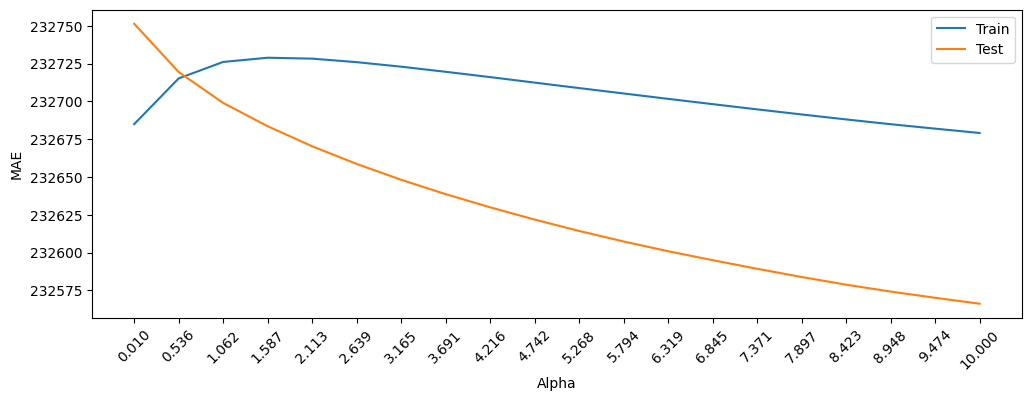

In [118]:
#Создаем список из 20 возможных значений от 0.001 до 10
alpha_list = np.linspace(0.01, 10, 20)
#Создаем пустые списки, в которые будем добавлять результаты
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаем объект класса линейная регрессия с L2-регуляризацией
    ridge_lr_scaled = Ridge(alpha=alpha, max_iter=10000)
    #Обучаем модель предсказывать логарифм целевого признака
    ridge_lr_scaled.fit(X_train_scaled, y_train_log)
    #Делаем предсказание для каждой из выборок
    #Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
    y_train_predict_scaled = np.exp(ridge_lr_scaled.predict(X_train_scaled))
    y_test_predict_scaled = np.exp(ridge_lr_scaled.predict(X_test_scaled))
    #Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_scaled))
    test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_scaled))

#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('MAE') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

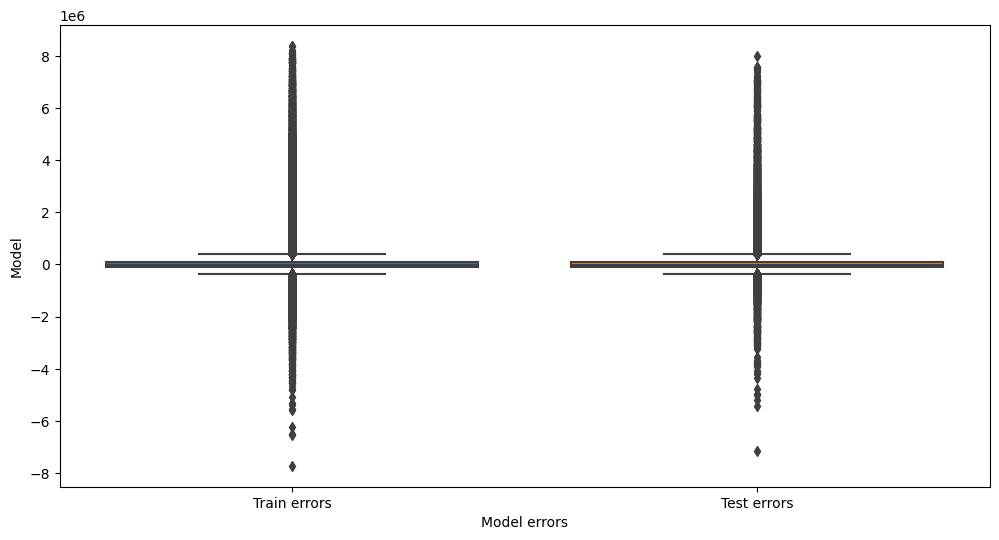

In [119]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке
y_train_errors = y_train - y_train_predict_scaled
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_predict_scaled
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors,
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

## Отбор лучших признаков

In [120]:
# Методы, основанные на F-тесте, оценивают степень линейной зависимости
# между двумя случайными величинами.  извлекаем лучшие 100 признаков.
bestfeatures = SelectKBest(score_func=f_regression, k=100)
fit = bestfeatures.fit(X_train, y_train)
# Создаем набор данных признаков с их весом и выбираем 100 лучших
featureScores =  pd.DataFrame({'Features':X_train.columns, 'Score': fit.scores_})
print(featureScores.nlargest(100,'Score'))

X_train_100 = X_train[featureScores.nlargest(100,'Score').Features.values]
X_test_100 = X_test[featureScores.nlargest(100,'Score').Features.values]

                                              Features         Score
5                                       schools_rating  13753.561632
95                                       baths_6 Baths  13291.307274
96                                       baths_7 Baths  12527.748592
93                                       baths_5 Baths  10441.613807
79                                       baths_2 Baths   9259.107991
..                                                 ...           ...
406  Cooling_Energy Star Qualified Equipment, High ...    116.769215
130                                   city_Clarksville    113.158588
360                                      Heating_other    111.869988
311                                           state_IL    111.359132
35                      status_pre foreclosure auction    110.349850

[100 rows x 2 columns]


## Поиск лучшей модели

In [121]:
# baseline на 100 признаках
model_lr_100 = LinearRegression()
model_lr_100.fit(X_train_100, y_train)
y_train_pred = model_lr_100.predict(X_train_100)
y_test_pred = model_lr_100.predict(X_test_100)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.444
Train MAE: 284165.383 $
Train MAPE: 70.649 %
--------------------
Test R^2: 0.443
Test MAE: 284654.427 $
Test MAPE: 69.985 %


In [122]:
# Дерево решений
dtr_100 = DecisionTreeRegressor(max_depth=12, random_state=42)
dtr_100.fit(X_train_100, y_train)
y_train_pred = dtr_100.predict(X_train_100)
y_test_pred = dtr_100.predict(X_test_100)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.689
Train MAE: 219967.953 $
Train MAPE: 63.918 %
--------------------
Test R^2: 0.617
Test MAE: 234159.103 $
Test MAPE: 65.157 %


In [123]:
# Случайный лес
rf_clf = RandomForestRegressor(
    n_estimators=400, # число деревьев
    max_depth=11, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель
rf_clf.fit(X_train_100, y_train)
y_train_pred = rf_clf.predict(X_train_100)
y_test_pred = rf_clf.predict(X_test_100)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.560
Train MAE: 261333.438 $
Train MAPE: 86.054 %
--------------------
Test R^2: 0.547
Test MAE: 263152.014 $
Test MAPE: 85.733 %


In [124]:
clf = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=7, min_samples_split=2, learning_rate=0.1)
clf.fit(X_train_100, y_train)
y_train_pred = clf.predict(X_train_100)
y_test_pred = clf.predict(X_test_100)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.745
Train MAE: 191524.324 $
Train MAPE: 48.842 %
--------------------
Test R^2: 0.714
Test MAE: 197283.094 $
Test MAPE: 48.874 %


In [125]:
SGDR = SGDRegressor()
SGDR.fit(X_train_100, y_train)
y_train_pred = SGDR.predict(X_train_100)
y_test_pred = SGDR.predict(X_test_100)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: -11507119625926484.000
Train MAE: 31811374381171.527 $
Train MAPE: 10598817414.399 %
--------------------
Test R^2: -12416511908418944.000
Test MAE: 31920786446114.234 $
Test MAPE: 10620114981.137 %


In [126]:
# Модель HistGradientBoostingRegressor
GBR = GradientBoostingRegressor()
GBR.fit(X_train, y_train)
y_train_pred = GBR.predict(X_train)
y_test_pred = GBR.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.647
Train MAE: 220988.432 $
Train MAPE: 60.850 %
--------------------
Test R^2: 0.645
Test MAE: 221045.007 $
Test MAPE: 60.061 %


In [127]:
HGBR = HistGradientBoostingRegressor()
HGBR.fit(X_train, y_train)
y_train_pred = GBR.predict(X_train)
y_test_pred = GBR.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.647
Train MAE: 220988.432 $
Train MAPE: 60.850 %
--------------------
Test R^2: 0.645
Test MAE: 221045.007 $
Test MAPE: 60.061 %


In [128]:
ABR = AdaBoostRegressor()
ABR.fit(X_train, y_train)
y_train_pred = ABR.predict(X_train)
y_test_pred = ABR.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: -0.655
Train MAE: 773550.058 $
Train MAPE: 292.978 %
--------------------
Test R^2: -0.656
Test MAE: 771538.908 $
Test MAPE: 292.335 %


In [129]:
CB = CatBoostRegressor()
CB.fit(X_train, y_train, verbose=False, plot=True)
y_train_pred = CB.predict(X_train)
y_test_pred = CB.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train R^2: 0.812
Train MAE: 157847.929 $
Train MAPE: 36.608 %
--------------------
Test R^2: 0.778
Test MAE: 163807.020 $
Test MAPE: 36.937 %


Наилучший результат показала модель "CatBoostRegressor", попробуем подобрать гиперпараметры.

# Подбор гиперпараметров

In [77]:
GSCV = GridSearchCV( CB, {
		"max_depth": range(10, 16, 1), 
 		"n_estimators" : range(10, 1000, 10), 
}, 
    cv = 3, 
    scoring = 'r2',
    n_jobs = -1
)

In [22]:
GSCV.fit(X_train,y_train)

Learning rate set to 0.105955
0:	learn: 728933.5108391	total: 268ms	remaining: 4m 3s
1:	learn: 691294.9189198	total: 543ms	remaining: 4m 6s
2:	learn: 658741.8578782	total: 843ms	remaining: 4m 14s
3:	learn: 630831.0880040	total: 1.16s	remaining: 4m 22s
4:	learn: 606587.1652683	total: 1.44s	remaining: 4m 20s
5:	learn: 584549.4868049	total: 1.71s	remaining: 4m 17s
6:	learn: 566169.7847049	total: 2s	remaining: 4m 18s
7:	learn: 549371.8993242	total: 2.27s	remaining: 4m 15s
8:	learn: 535111.6024038	total: 2.58s	remaining: 4m 18s
9:	learn: 521761.9818668	total: 2.88s	remaining: 4m 19s
10:	learn: 510709.4444763	total: 3.17s	remaining: 4m 19s
11:	learn: 500276.3853866	total: 3.46s	remaining: 4m 18s
12:	learn: 491175.2737191	total: 3.73s	remaining: 4m 17s
13:	learn: 483523.4404587	total: 4s	remaining: 4m 16s
14:	learn: 476432.5857902	total: 4.27s	remaining: 4m 14s
15:	learn: 469613.3773978	total: 4.53s	remaining: 4m 13s
16:	learn: 464023.4227383	total: 4.81s	remaining: 4m 12s
17:	learn: 458595.9

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000021A515744F0>,
             n_jobs=-1,
             param_grid={'max_depth': range(10, 16),
                         'n_estimators': range(10, 1000, 10)},
             scoring='r2')

Поиск гиперпараметров занял примерно 3 дня, GridSearchCV запускался несколько раз в разных диапазонах. тут представлен самый успешный.

In [ ]:
GSCV.best_estimator_

# Сериализация

### Модель

In [130]:
with open('Model.pkl', 'rb') as pkl_file:
    regressor_from_file = pickle.load(pkl_file)

regressor_from_bytes = pickle.loads(regressor_from_file)

model = regressor_from_bytes


In [ ]:
model = GSCV.best_estimator_

###  Создание пайплайна

In [135]:
pipe = Pipeline([  
  ('Scaling', MinMaxScaler()),
  ('FeatureSelection', SelectKBest(score_func=f_regression, k=500)),
  ('Model', model)
  ])
pipe.fit(X_train, y_train)

Learning rate set to 0.105955
0:	learn: 728933.5108391	total: 234ms	remaining: 3m 32s
1:	learn: 691294.9189198	total: 453ms	remaining: 3m 25s
2:	learn: 658741.8578782	total: 677ms	remaining: 3m 24s
3:	learn: 630831.0880040	total: 923ms	remaining: 3m 29s
4:	learn: 606587.1652683	total: 1.19s	remaining: 3m 34s
5:	learn: 584549.4868049	total: 1.42s	remaining: 3m 33s
6:	learn: 566169.7847049	total: 1.64s	remaining: 3m 31s
7:	learn: 549371.8993242	total: 1.86s	remaining: 3m 30s
8:	learn: 535111.6024038	total: 2.14s	remaining: 3m 34s
9:	learn: 521761.9818668	total: 2.37s	remaining: 3m 33s
10:	learn: 510709.4444763	total: 2.58s	remaining: 3m 31s
11:	learn: 500276.3853866	total: 2.81s	remaining: 3m 30s
12:	learn: 491175.2737191	total: 3.07s	remaining: 3m 31s
13:	learn: 483523.4404587	total: 3.33s	remaining: 3m 33s
14:	learn: 476432.5857902	total: 3.54s	remaining: 3m 31s
15:	learn: 469613.3773978	total: 3.76s	remaining: 3m 29s
16:	learn: 464023.4227383	total: 4.01s	remaining: 3m 30s
17:	learn: 

Pipeline(steps=[('Scaling', MinMaxScaler()),
                ('FeatureSelection',
                 SelectKBest(k=500,
                             score_func=<function f_regression at 0x000002496EE1EF70>)),
                ('Model',
                 <catboost.core.CatBoostRegressor object at 0x00000249710A67F0>)])

In [136]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.933
Train MAE: 105729.939 $
Train MAPE: 26.411 %
--------------------
Test R^2: 0.816
Test MAE: 141945.534 $
Test MAPE: 30.676 %


In [137]:
pipeline = pickle.dumps(pipe)

with open('PipeLine.pkl', 'wb') as output:
    pickle.dump(pipeline, output)